In [1]:
import sys
sys.path.append("..")


In [2]:
import os
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import json
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

from models.model_v2 import PlantDiseaseResNet18
from utils.grad_cam_v1 import visualize_single_image, export_batch_visualizations
from PIL import Image

from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, confusion_matrix,
                             classification_report)


from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

In [3]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
    print(f"Using GPU: {device}")
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    
else:
    print("CUDA not available!")
print(f"Running on {device}")

Running on cuda:1
Using GPU: cuda:1
GPU Name: Tesla P100-PCIE-12GB
Running on cuda:1


In [4]:
checkpoint_path = "../models/model_v2.pth"   
train_dir = "/home/sonia/RM/PlantVillage_split/train"    
val_dir = "/home/sonia/RM/PlantVillage_split/val"        
test_dir = "/home/sonia/RM/PlantVillage_split/test"

In [5]:
num_classes = 15                           
batch_size = 32
epochs = 5
lr = 1e-3
freeze_backbone = True    
save_out = "../models/model_v2_user1.pth"

num_workers = 2
pin_memory = True if torch.cuda.is_available() else False

In [6]:

def make_dataloaders(train_dir, val_dir, test_dir, batch_size):
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    train_loader, train_map = None, None
    if train_dir and os.path.isdir(train_dir):
        train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=pin_memory)
        train_map = train_ds.class_to_idx

    val_loader = None
    if val_dir and os.path.isdir(val_dir):
        val_ds = datasets.ImageFolder(val_dir, transform=eval_tf)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=pin_memory)

    if not os.path.isdir(test_dir):
        raise FileNotFoundError(test_dir)

    test_ds = datasets.ImageFolder(test_dir, transform=eval_tf)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    test_map = test_ds.class_to_idx

    return train_loader, val_loader, test_loader, train_map, test_map


In [7]:

def build_model_and_load_backbone(checkpoint_path, num_classes, device):
   
    model = PlantDiseaseResNet18(num_classes=num_classes, pretrained=False)
    model = model.to(device)

    ckpt = torch.load(checkpoint_path, map_location="cpu")
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    new_state = {}
    for k,v in state_dict.items():
        if k.startswith("module."):
            k = k[len("module."):]
        new_state[k] = v

    model_state = model.state_dict()

    loadable = {}
    adapted = []
    skipped = []

    for k,v in new_state.items():
        if k not in model_state:
            skipped.append(k)
            continue

        if tuple(model_state[k].shape) == tuple(v.shape):
            loadable[k] = v
            continue

        if k.endswith('.weight') and len(model_state[k].shape) == 2 and len(v.shape) == 2 and model_state[k].shape[1] == v.shape[1]:
            new_w = model_state[k].clone()
            rows_to_copy = min(v.shape[0], model_state[k].shape[0])
            if rows_to_copy > 0:
                new_w[:rows_to_copy].copy_(v[:rows_to_copy])
            loadable[k] = new_w
            adapted.append(k)
            continue

        if k.endswith('.bias') and len(model_state[k].shape) == 1 and len(v.shape) == 1:
            new_b = model_state[k].clone()
            elems_to_copy = min(v.shape[0], model_state[k].shape[0])
            if elems_to_copy > 0:
                new_b[:elems_to_copy].copy_(v[:elems_to_copy])
            loadable[k] = new_b
            adapted.append(k)
            continue

        skipped.append(k)

    print(f"Checkpoint keys: {len(new_state)}; loadable keys: {len(loadable)}; adapted keys: {len(adapted)}; skipped keys: {len(skipped)} (expected if head shapes differ)")

    model_state.update(loadable)
    model.load_state_dict(model_state)

    try:
        model._loader_info = {'loadable': list(loadable.keys()), 'adapted': adapted, 'skipped': skipped}
    except Exception:
        pass

    return model


In [8]:

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total, correct, running_loss = 0, 0, 0.0

    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    return running_loss/total, correct/total


In [9]:
def evaluate(model, loader, criterion, device, class_to_idx=None):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0

    per_correct = {}
    per_total = {}

    with torch.no_grad():
        for images, labels in tqdm(loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += images.size(0)

            for t,p in zip(labels.cpu(), preds.cpu()):
                per_total[t.item()] = per_total.get(t.item(), 0) + 1
                if t == p:
                    per_correct[t.item()] = per_correct.get(t.item(), 0) + 1

    avg_loss = running_loss/total
    avg_acc = correct/total

    idx_to_class = {v:k for k,v in class_to_idx.items()} if class_to_idx else None
    per_report = {}

    for idx, tot in per_total.items():
        corr = per_correct.get(idx, 0)
        name = idx_to_class[idx] if idx_to_class else str(idx)
        per_report[name] = {"correct": corr, "total": tot, "acc": corr/tot}

    return avg_loss, avg_acc, per_report

In [10]:

train_loader, val_loader, test_loader, train_map, test_map = make_dataloaders(
    train_dir, val_dir, test_dir, batch_size
)

print("Train classes:", len(train_map) if train_map else 0)
print("Test classes:", len(test_map))

model = build_model_and_load_backbone(checkpoint_path, num_classes, device)
print("Model built and backbone loaded (classifier kept/adapted as defined in PlantDiseaseResNet18).")

loader_info = getattr(model, '_loader_info', None)
if loader_info is not None:
    print(f"Loader: loadable={len(loader_info.get('loadable',[]))}, adapted={len(loader_info.get('adapted',[]))}, skipped={len(loader_info.get('skipped',[]))}")

print('\nClassifier parameters:')
for name, p in model.named_parameters():
    if name.startswith('classifier'):
        print(name, tuple(p.shape), 'requires_grad=', p.requires_grad)

num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model.parameters())
print(f"\nTrainable params: {num_trainable} / {num_total}")


if freeze_backbone:
    model.freeze_backbone()
    print("Backbone frozen — training classifier only.")
else:
    model.unfreeze_backbone()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

best_val = 0
if train_loader:
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}")

        if val_loader:
            val_loss, val_acc, _ = evaluate(model, val_loader, criterion, device, class_to_idx=train_map)
            print(f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

            if val_acc > best_val:
                best_val = val_acc
                torch.save({"state_dict": model.state_dict()}, save_out)
                print("Saved best model:", save_out)

    if not val_loader:
        torch.save({"state_dict": model.state_dict()}, save_out)
        print("Saved final model.")

print("\nEvaluating on TEST set (final) ...")
model.eval()
test_loss, test_acc, test_rep = evaluate(model, test_loader, criterion, device, class_to_idx=train_map)
print(f"\nTEST: loss={test_loss:.4f}, acc={test_acc:.4f}")

for cls, stats in sorted(test_rep.items()):
    print(f"{cls}: {stats['correct']}/{stats['total']} acc={stats['acc']:.3f}")

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)                          
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

if 'test_dataset' in globals() and hasattr(test_map, 'classes'):
    class_names = list(test_map.classes)
else:
    class_names = list(test_loader.dataset.classes) if hasattr(test_loader.dataset, 'classes') else None

if class_names is None:
    n_classes = int(max(all_labels.max(), all_preds.max()) + 1)
    class_names = [str(i) for i in range(n_classes)]

n_classes = len(class_names)

acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=np.arange(n_classes), zero_division=0
)

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(n_classes))

per_class_acc = []
for i in range(n_classes):
    row_sum = cm[i].sum()
    if row_sum == 0:
        per_class_acc.append(0.0)
    else:
        per_class_acc.append(cm[i, i] / row_sum)

metrics = {
    "summary": {
        "accuracy": float(acc),
        "num_samples": int(len(all_labels))
    },
    "per_class": {},
    "confusion_matrix": cm.tolist(),
    "class_names": class_names
}

for i, cls in enumerate(class_names):
    metrics["per_class"][cls] = {
        "precision": float(precision[i]),
        "recall": float(recall[i]),
        "f1": float(f1[i]),
        "support": int(support[i]),
        "accuracy": float(per_class_acc[i])
    }

print("\n==================== MODEL EVALUATION (TEST) ====================\n")
print(f"Overall Accuracy : {acc:.4f}    (Total samples = {len(all_labels)})\n")

print("==================== PER-CLASS METRICS ====================\n")
print(f"{'Class':40s} {'Prec':>7s} {'Rec':>7s} {'F1':>7s} {'Acc':>7s} {'Support':>8s}")
print("-" * 82)
for i, cls in enumerate(class_names):
    print(f"{cls:40s} "
          f"{precision[i]:7.3f} {recall[i]:7.3f} {f1[i]:7.3f} "
          f"{per_class_acc[i]:7.3f} {support[i]:8d}")

import pandas as pd
table_df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Accuracy": per_class_acc,
    "Support": support
}).sort_values(by="Class")

print("\n==================== PER-CLASS METRICS (TABLE) ====================\n")
display(table_df)

out_json = "../results/test_metrics_v2_user1.json"
os.makedirs(os.path.dirname(out_json), exist_ok=True)
with open(out_json, "w") as fh:
    json.dump(metrics, fh, indent=4)
print(f"Saved metrics JSON to: {out_json}")

torch.save({"state_dict": model.state_dict()}, save_out)
print("Saved:", save_out)


Train classes: 15
Test classes: 15
Checkpoint keys: 133; loadable keys: 133; adapted keys: 2; skipped keys: 0 (expected if head shapes differ)
Model built and backbone loaded (classifier kept/adapted as defined in PlantDiseaseResNet18).
Loader: loadable=133, adapted=2, skipped=0

Classifier parameters:
classifier.0.weight (512, 512) requires_grad= True
classifier.0.bias (512,) requires_grad= True
classifier.1.weight (512,) requires_grad= True
classifier.1.bias (512,) requires_grad= True
classifier.4.weight (15, 512) requires_grad= True
classifier.4.bias (15,) requires_grad= True

Trainable params: 11481199 / 11481199
Backbone frozen — training classifier only.

Epoch 1/5


Train: loss=0.8566, acc=0.7658


Val:   loss=0.1764, acc=0.9395
Saved best model: ../models/model_v2_user1.pth

Epoch 2/5


Train: loss=0.4280, acc=0.8606


Val:   loss=0.1324, acc=0.9540
Saved best model: ../models/model_v2_user1.pth

Epoch 3/5


Train: loss=0.3781, acc=0.8742


Val:   loss=0.1441, acc=0.9511

Epoch 4/5


Train: loss=0.3578, acc=0.8805


Val:   loss=0.1285, acc=0.9566
Saved best model: ../models/model_v2_user1.pth

Epoch 5/5


Train: loss=0.3457, acc=0.8821


Val:   loss=0.1132, acc=0.9615
Saved best model: ../models/model_v2_user1.pth

Evaluating on TEST set (final) ...



TEST: loss=0.1165, acc=0.9617
Pepper__bell___Bacterial_spot: 146/151 acc=0.967
Pepper__bell___healthy: 222/223 acc=0.996
Potato___Early_blight: 149/150 acc=0.993
Potato___Late_blight: 142/150 acc=0.947
Potato___healthy: 23/24 acc=0.958
Tomato_Bacterial_spot: 315/320 acc=0.984
Tomato_Early_blight: 139/150 acc=0.927
Tomato_Late_blight: 265/287 acc=0.923
Tomato_Leaf_Mold: 137/144 acc=0.951
Tomato_Septoria_leaf_spot: 261/267 acc=0.978
Tomato_Spider_mites_Two_spotted_spider_mite: 248/252 acc=0.984
Tomato__Target_Spot: 177/212 acc=0.835
Tomato__Tomato_YellowLeaf__Curl_Virus: 471/482 acc=0.977
Tomato__Tomato_mosaic_virus: 57/57 acc=1.000
Tomato_healthy: 238/240 acc=0.992



==================== MODEL EVALUATION (TEST) ====================

Overall Accuracy : 0.9617    (Total samples = 3109)

==================== PER-CLASS METRICS ====================

Class                                       Prec     Rec      F1     Acc  Support
----------------------------------------------------------------------------------
Pepper__bell___Bacterial_spot              0.973   0.967   0.970   0.967      151
Pepper__bell___healthy                     0.974   0.996   0.984   0.996      223
Potato___Early_blight                      0.987   0.993   0.990   0.993      150
Potato___Late_blight                       0.966   0.947   0.956   0.947      150
Potato___healthy                           1.000   0.958   0.979   0.958       24
Tomato_Bacterial_spot                      0.952   0.984   0.968   0.984      320
Tomato_Early_blight                        0.914   0.927   0.921   0.927      150
Tomato_Late_blight                         0.974   0.923   0.948   0.923      2

,Class,Precision,Recall,F1-score,Accuracy,Support
0,Pepper__bell___Bacterial_spot,0.973333,0.966887,0.970100,0.966887,151
1,Pepper__bell___healthy,0.973684,0.995516,0.984479,0.995516,223
2,Potato___Early_blight,0.986755,0.993333,0.990033,0.993333,150
3,Potato___Late_blight,0.965986,0.946667,0.956229,0.946667,150
4,Potato___healthy,1.000000,0.958333,0.978723,0.958333,24
5,Tomato_Bacterial_spot,0.951662,0.984375,0.967742,0.984375,320
6,Tomato_Early_blight,0.914474,0.926667,0.920530,0.926667,150
7,Tomato_Late_blight,0.974265,0.923345,0.948122,0.923345,287
8,Tomato_Leaf_Mold,0.978571,0.951389,0.964789,0.951389,144
9,Tomato_Septoria_leaf_spot,0.977528,0.977528,0.977528,0.977528,267


Saved metrics JSON to: ../results/test_metrics_v2_user1.json
Saved: ../models/model_v2_user1.pth


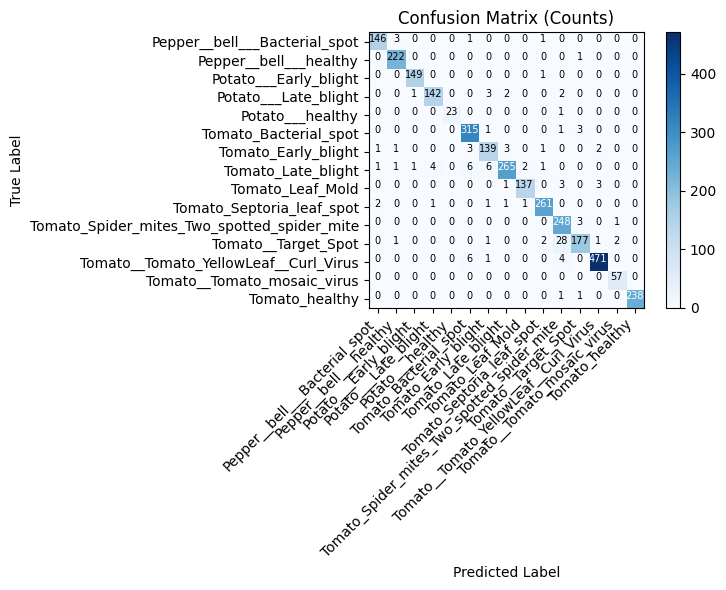

Saved: ../results/v2_user1/plots_test_v2/confusion_matrix_counts.png


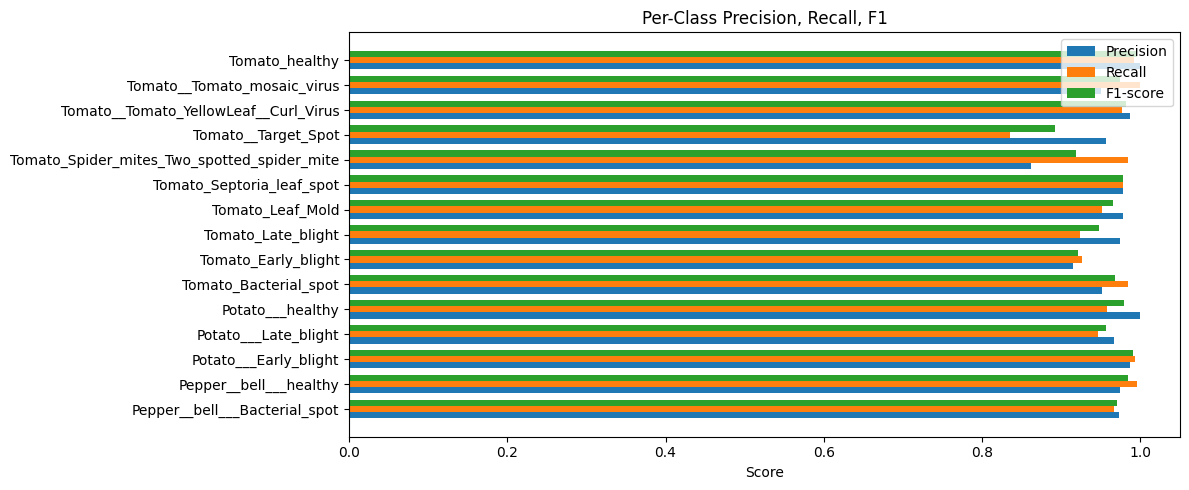

Saved: ../results/v2_user1/plots_test_v2/per_class_prf.png


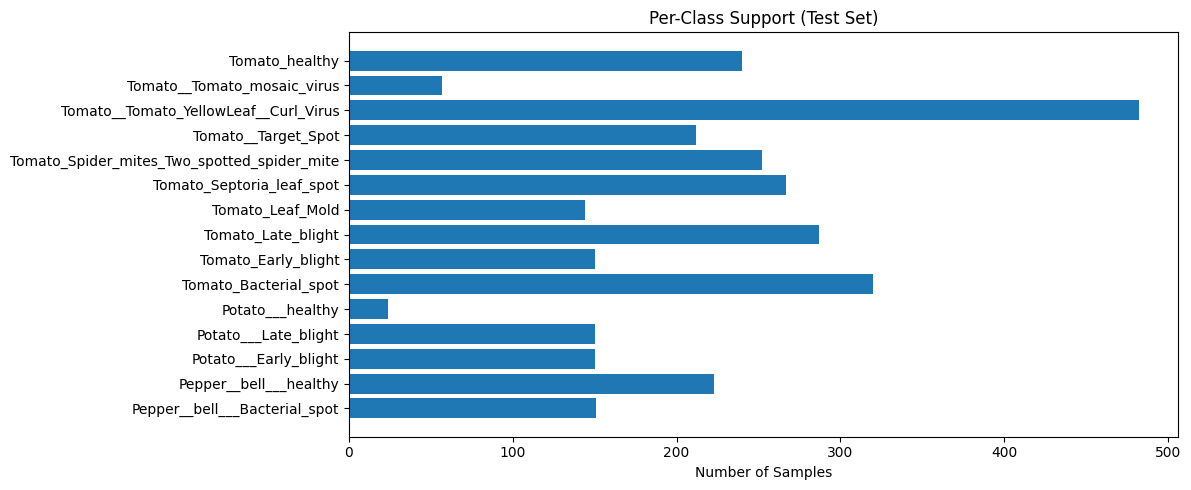

Saved: ../results/v2_user1/plots_test_v2/per_class_support.png


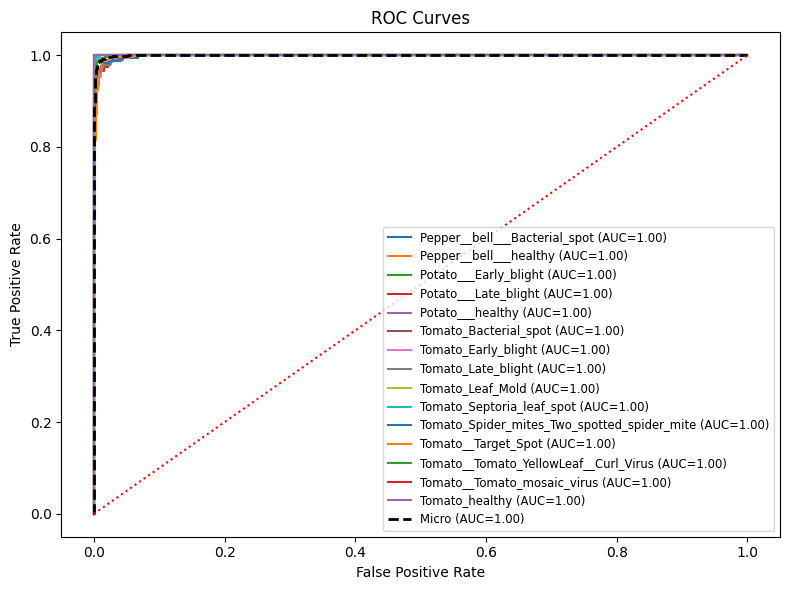

Saved: ../results/v2_user1/plots_test_v2/roc_curves.png


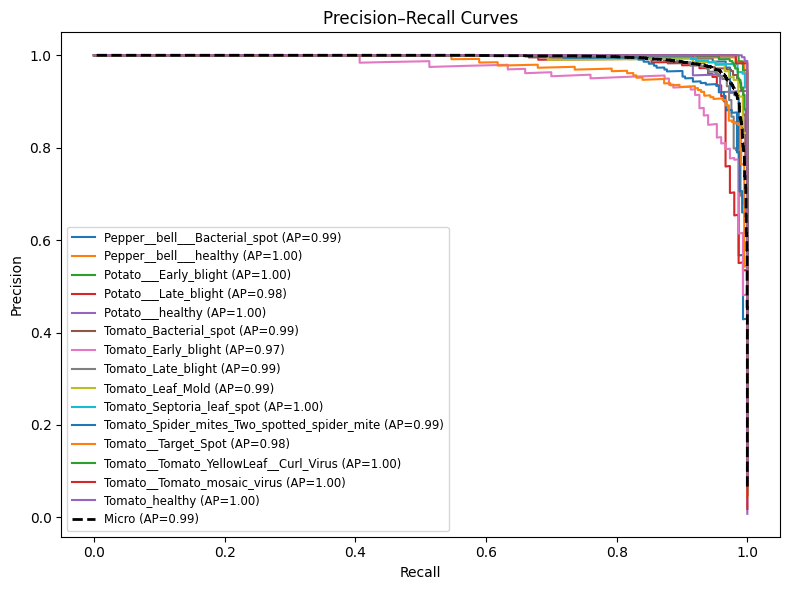

Saved: ../results/v2_user1/plots_test_v2/pr_curves.png

All test plots saved to: ../results/v2_user1/plots_test_v2


In [11]:
plots_dir = "../results/v2_user1/plots_test_v2"
os.makedirs(plots_dir, exist_ok=True)

if 'metrics' not in globals():
    with open("testSample//metrics_v1.json", "r") as f:
        metrics = json.load(f)

if 'test_dataset' in globals():
    class_names = list(test_map.classes)
else:
    class_names = metrics["class_names"]

n_classes = len(class_names)

# ----- 1) Confusion Matrix -----
cm = np.array(metrics["confusion_matrix"])

plt.figure(figsize=(max(8,n_classes*0.4), max(6,n_classes*0.3)))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Counts)")
plt.colorbar()
ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)

thresh = cm.max() / 2
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, str(int(cm[i,j])),
                 ha="center",
                 color="white" if cm[i,j] > thresh else "black",
                 fontsize=7)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
p = os.path.join(plots_dir, "confusion_matrix_counts.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)



# ----- 3) Per-class metrics -----
prec = []
rec = []
f1 = []
support = []

for cls in class_names:
    m = metrics["per_class"][cls]
    prec.append(m["precision"])
    rec.append(m["recall"])
    f1.append(m["f1"])
    support.append(m["support"])

x = np.arange(n_classes)
width = 0.25

plt.figure(figsize=(12, max(5, n_classes*0.25)))
plt.barh(x - width, prec, height=width, label="Precision")
plt.barh(x, rec, height=width, label="Recall")
plt.barh(x + width, f1, height=width, label="F1-score")
plt.yticks(x, class_names)
plt.xlabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.legend()
plt.tight_layout()
p = os.path.join(plots_dir, "per_class_prf.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)

# ----- 4) Per-class Support -----
plt.figure(figsize=(12, max(5, n_classes*0.25)))
plt.barh(class_names, support)
plt.xlabel("Number of Samples")
plt.title("Per-Class Support (Test Set)")
plt.tight_layout()
p = os.path.join(plots_dir, "per_class_support.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)

# ----- 5) ROC & PR curves -----
have_probs = ('all_probs' in globals()) and len(all_probs) > 0

if have_probs:
    y_true = np.array(all_labels)
    y_score = np.array(all_probs)

    Y = label_binarize(y_true, classes=np.arange(n_classes))

    # ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    fpr, tpr, _ = roc_curve(Y.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', lw=2, label=f"Micro (AUC={roc_auc:.2f})")

    plt.plot([0,1],[0,1], 'r:')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize="small")
    p = os.path.join(plots_dir, "roc_curves.png")
    plt.tight_layout()
    plt.savefig(p, dpi=150)
    plt.show()
    plt.close()
    print("Saved:", p)

    # Precision-Recall Curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        pr, rc, _ = precision_recall_curve(Y[:, i], y_score[:, i])
        ap = average_precision_score(Y[:, i], y_score[:, i])
        plt.plot(rc, pr, label=f"{class_names[i]} (AP={ap:.2f})")

    pr_micro, rc_micro, _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    ap_micro = average_precision_score(Y, y_score, average="micro")
    plt.plot(rc_micro, pr_micro, 'k--', lw=2, label=f"Micro (AP={ap_micro:.2f})")

    plt.title("Precision–Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(fontsize="small")
    p = os.path.join(plots_dir, "pr_curves.png")
    plt.tight_layout()
    plt.savefig(p, dpi=150)
    plt.show()

    plt.close()
    print("Saved:", p)

else:
    print("Skipping ROC/PR curves — no probabilities (all_probs) available.")

print("\nAll test plots saved to:", plots_dir)

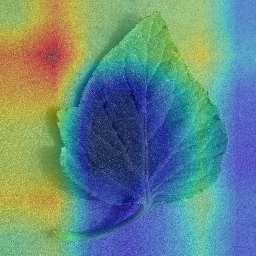

Successfully saved 20 Grad-CAM visualizations to ../results/v2_user1/gradcam_v2user1


In [12]:
image_preprocessing = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_image_path = '/home/sonia/RM/PlantVillage_split/test/Tomato__Target_Spot/0b0e5158-180e-487c-b4a7-1ee496473147___Com.G_TgS_FL 9932.JPG'
test_image = Image.open(test_image_path).convert('RGB')
overlay_result, activation_heatmap, predicted_class = visualize_single_image(
    model, test_image, image_preprocessing, computation_device=device)
display(overlay_result)
gradcam_category_names = [k for k,_ in sorted(test_map.items(), key=lambda it: it[1])] if isinstance(test_map, dict) else None
export_batch_visualizations(
    network=model,
    data_loader=val_loader,
    category_names=gradcam_category_names,
    preprocessing=image_preprocessing,
    output_directory="../results/v2_user1/gradcam_v2user1",
    sample_count=20,
    computation_device=device
)